# XGBoost

In this note book we will try to  use an XGboost model to predict if runners will get injured based on their previous 7 days of training. We were initially unsuccessful in doing so with a logistic regression, but have opted to use an XGBoost model instead, seeing as it is an ensemble model, fitting the following tree based on the residuals of the last, ergo building on its mistakes. Additionally it has hyper parameters (subsample, scale_pos_weight) which aid further in dealing with imbalanced classes, like we find in our dataset.

## Table of contents
1. [Reading in and Preparing the Data](#Reading-in-and-Preparing-the-Data)
2. [Initial Base-model](#Initial-Base-model)
3. [Tuning XGB hyperparameters](#Tuning-XGB-hyperparameters)
4. [Grid search](#Grid-search)
5. [Randomized Search](#Randomized-Search)
6. [Randomized Search Attempt 2](#Randomized-Search-Attempt-2)
7. [Model Evaluation on True Test Set](#Model-Evaluation-on-True-Test-Set)
8. [Conclusion](#Conclusion)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler


# Reading in and Preparing the Data

In [2]:
#READING IN THE DATA
running_df=pd.read_csv('running_df_cleaned.csv', index_col=0)
running_df #sanity check

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,...,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1.0,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,...,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,...,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42761,1.0,16.0,0.0,0.0,0.0,0.0,0.00,0.54,0.22,0.30,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,71,1,2143
42762,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,71,1,2286
42763,1.0,10.0,0.0,0.0,0.0,0.0,0.00,0.94,0.88,0.11,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,71,1,2483
42764,1.0,15.1,0.0,0.0,0.0,0.0,0.00,0.87,0.86,0.20,...,0.0,0.0,0.0,0.0,0.79,0.80,0.11,71,1,2647


Now we will split our data into train, validation and test.

In [3]:
# ATTEMPT AT XG BOOST
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


X=running_df.drop(['injury'], axis= 1)
y=running_df['injury']

#split into test and validation
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify= y)



In [4]:
#splitting remainder into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1)


# Initial Base-model

In [5]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)
print(f"XG Boost score: {XGB_model.score(X_validation, y_validation)}")


XG Boost score: 0.9853865263773199


Like our prior logreg model, we see a fairly high inital score but this is based off accuracy, we will plot a confusion matrix and classification report to check the f1_scores.

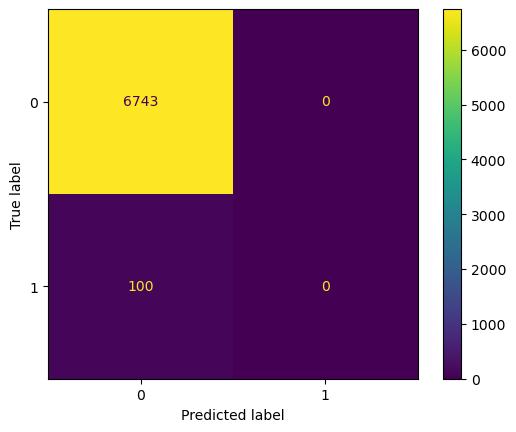

In [6]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

plot_confusion_matrix(XGB_model, X_validation, y_validation)

In [7]:
from sklearn.metrics import classification_report

y_pred=XGB_model.predict(X_validation)

print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6743
           1       0.00      0.00      0.00       100

    accuracy                           0.99      6843
   macro avg       0.49      0.50      0.50      6843
weighted avg       0.97      0.99      0.98      6843



As predicted, our our inital model again defaulted to classifying all points as non-injury, the far more prevelant class. 

# Manually Tuning Hyper Parameters

We will start tuning the hyper parameters manually to get a range, which can later be narrowed down using a gridsearch. First we will fnid a range for number of estimators. 

## Adding Scale Pos weight

Off the bat we will implement XGB's parameter `scale post weight`, as it accounts for class imbalances, like the one we are expereincing.

We will use the inverse of the class imbalance, as recommended by several sources.
Source: https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [8]:
np.unique(y_train, return_counts= True)


(array([0, 1]), array([27003,   366]))

In [9]:
from math import sqrt

print(29528/408)


72.37254901960785


Virtually all of the weights are within 98%, so for the sake of preventing assuming all points are injury, we will stay bellow 98%, there fore, 80<. Our range will be 80-100. Instead of leaving a range we will choose an artbitrary number within this range- in this case 80.

# Number of Estimators

In [10]:
#finding number of estimators
estimators_list = range(1, 500, 50)

train_scores = []
validation_scores = []

for n in estimators_list:
    print(f"Working on n={n}...", end="\r") 
    
    XGB_model_tuning = XGBClassifier(n_estimators=n, n_jobs= -1, scale_pos_weight=72.3)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation, ))
    

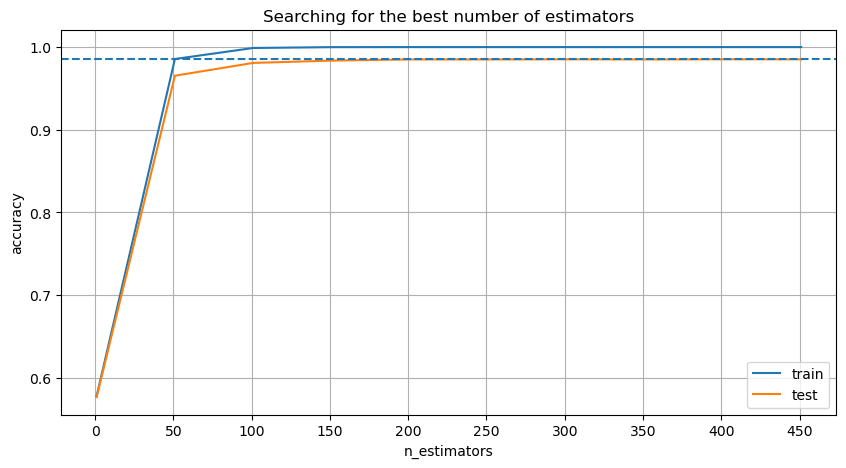

In [11]:
#plotting results
pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=estimators_list
).plot(figsize=(10, 5))
plt.title("Searching for the best number of estimators")
plt.xticks(np.arange(0, 500, step=50))
plt.axhline(0.986, linestyle = '--') 
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.grid()
plt.show()

We can see that after around estimators 100 the model begins to level out at 98.6, meaning it is predicting everything as a non-injury. We will dis regard the values past 100 and run the model again with a smaller range and step size.

In [12]:
#narrowing range of estimators
estimators_list = range(0, 150, 5)

train_scores = []
validation_scores = []

for n in estimators_list:
    print(f"Working on n={n}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(n_estimators=n, n_jobs= -1, scale_pos_weight=72.3)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))
    

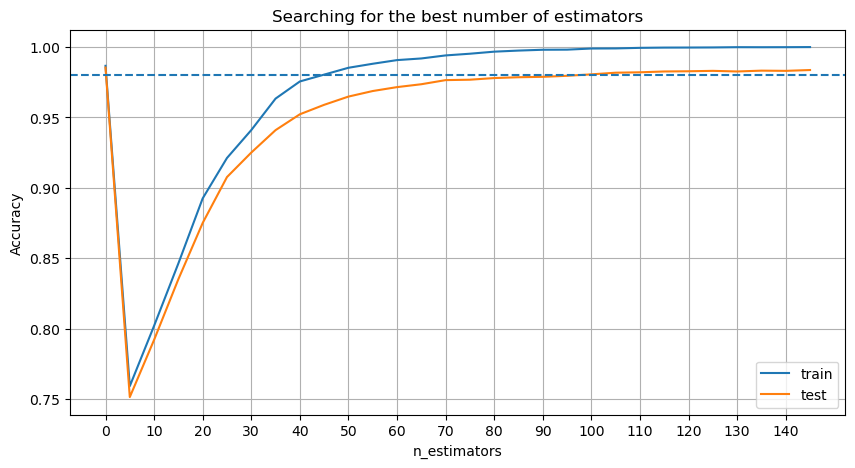

In [13]:
#ex of formatt to follow 

pd.DataFrame({"train": train_scores, "test": validation_scores}, index=estimators_list).plot(figsize=(10, 5))
plt.title("Searching for the best number of estimators")
plt.xticks(np.arange(0, 150, step=10))
plt.axhline(0.98, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.grid()
plt.show()

We have an axhline set to 98% so that we stay bellow the 98.6% mark. We can seee that at around 90 estimators it intercepts this line so we will keep our range of **estimators between 5 and 90**; leaving a wider buffer on the lower end.


##  Max depth
Next we will optimize max depth.

In [14]:
#ex of formatt to follow 
maxdepth_list = range(1, 8, 1)

train_scores = []
validation_scores = []

for d in maxdepth_list:
    print(f"Working on d={d}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(max_depth=d, n_jobs= -1, scale_pos_weight=72.3)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))
    

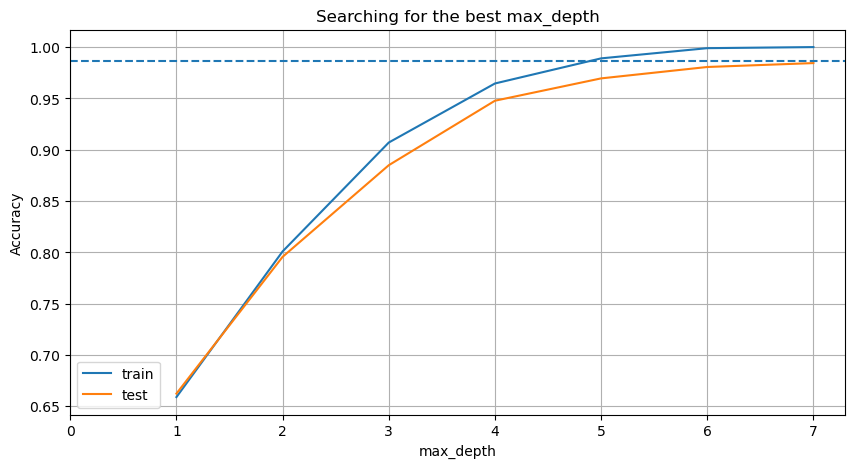

In [15]:
#ex of formatt to follow 

pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=maxdepth_list
).plot(figsize=(10, 5))
plt.title("Searching for the best max_depth")
plt.xticks(np.arange(0, 8, step=1))
plt.axhline(0.986, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('max_depth')
plt.grid()
plt.show()

At a max depth of 6 we can see that our acccruacy plateaus at 98% so we shall usea **max depth range of 2-5** in our gridsearch; again leaving a wider buffer on the lower end.

## Subsample

Sub sample controls **how much of is taken from the prvious tree?** , and ranges between 0.1-1

In [16]:
#finding an optimal range for the subsample
sub_sample_list = [.1, .2, .3, .4, .5, .6, .7, .8,.9, 1]


train_scores = []
validation_scores = []

for d in sub_sample_list:
    print(f"Working on d={d}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(subsample=d, n_jobs= -1, scale_pos_weight=72.3)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))

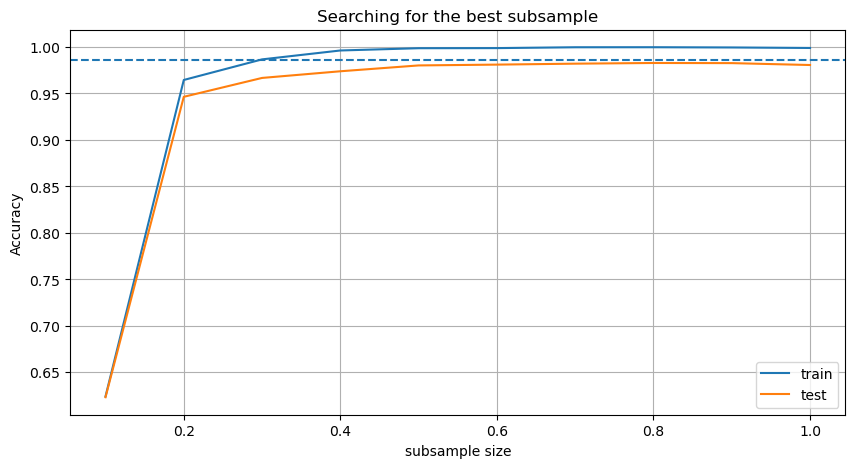

In [17]:
pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=sub_sample_list
).plot(figsize=(10, 5))
plt.title("Searching for the best subsample")
plt.axhline(0.986, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('subsample size')
plt.grid()
plt.show()

At .8 we get too close to 98% so our range will be betwen 0.2 and 0.7.

# Learning Rate

In [18]:
#finding an optimal range for the subsample
Learning_Rate_list = [.1, .2, .3, .4, .5, .6, .7, .8,.9, 1]


train_scores = []
validation_scores = []

for d in sub_sample_list:
    print(f"Working on d={d}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(subsample=d, n_jobs= -1, scale_pos_weight=72.3)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))

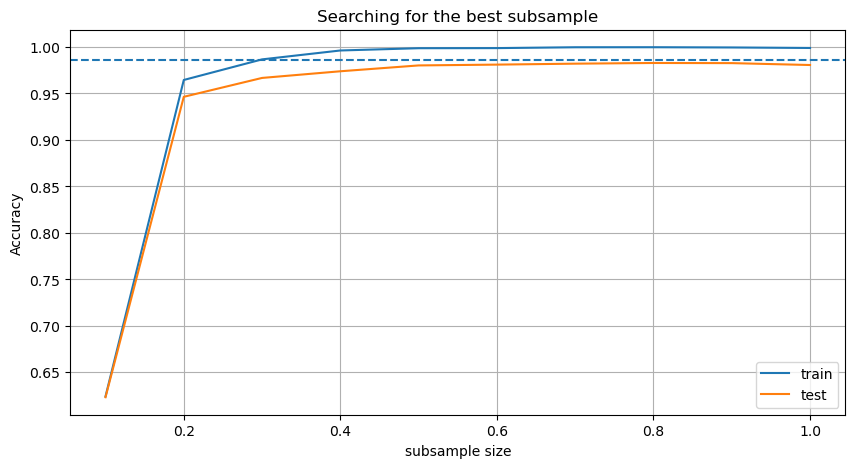

In [19]:
pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=sub_sample_list
).plot(figsize=(10, 5))
plt.title("Searching for the best subsample")
plt.axhline(0.986, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('subsample size')
plt.grid()
plt.show()

# Max Delta Step
 max_delta_steps do is to introduce an 'absolute' regularization capping the weight before apply eta correction.

Source: https://stats.stackexchange.com/questions/233248/max-delta-step-in-xgboost

In [20]:
#finding an optimal range for the subsample
delta_step_list = range(0,10, 1)


train_scores = []
validation_scores = []

for d in delta_step_list:
    print(f"Working on d={d}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(max_delta_step=d, n_jobs= -1, scale_pos_weight=72.3)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))

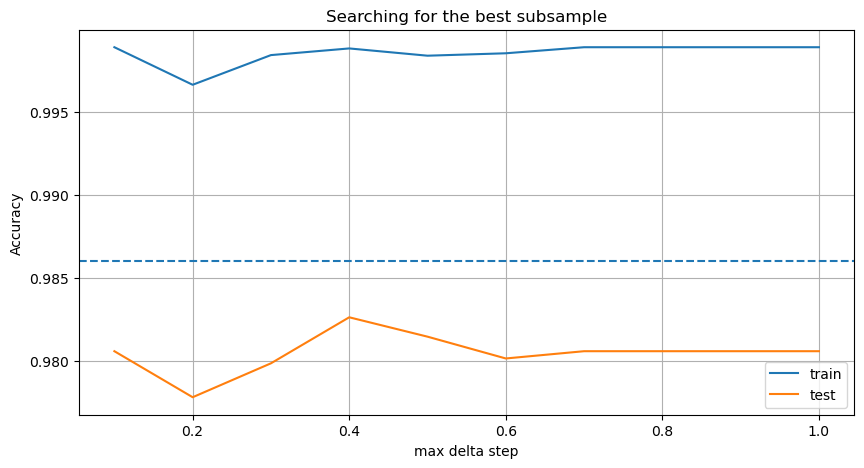

In [21]:
pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=sub_sample_list
).plot(figsize=(10, 5))
plt.title("Searching for the best subsample")
plt.axhline(0.986, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('max delta step')
plt.grid()
plt.show()

little to no effect on the data, will likely leave out

**Note on scorring**: it is also important to note  before our grid search, that we search will be selecting best model based on f1-score as that better reflects propper classificaiton of injury vs non injury (including true/false positives/negatives). With that being said, we will add a buffer to our previously established ranges as those were established using accuracy not f1.

#  Random search
Given that our prior Logistic Regression models and inital XGBoost model performed so poorly, before commiting to a slightly more time comsuming and thorough gridsearch, we will do some inital attempts with the faster option of a Random Search. 

## Random Search Attempt 1

In [163]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline


from sklearn.metrics import make_scorer

f1_micro= make_scorer(f1_score, average='micro')

estimators = [
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
]

# create pipeline
xgb_pipe = Pipeline(estimators)


param_grid = [
    {
        'model': [XGBClassifier(scale_pos_weight=72.3)],
        'scaler': [StandardScaler()],
        'model__subsample':[0.2, 0.4, 0.6, 0.7],
        'model__max_depth': [2, 3, 4, 5],
        'model__n_estimators': range(5, 90, 5 ),
    }
]

Randomgrid = RandomizedSearchCV(xgb_pipe, param_grid, cv=5, verbose=3, scoring = 'f1', random_state=1, n_iter=50, n_jobs=-1)

fitted_randomgrid = Randomgrid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   2.0s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gp

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   1.9s
[CV 5/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   1.2s
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 5/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   1.9s
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   1.2s
[CV 5/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 5/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=85, model__subsample=0.4, scaler=StandardScaler(); total time=   7.5s
[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [165]:
fitted_randomgrid.best_score_

0.06668373049553235

[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=85, model__subsample=0.4, scaler=StandardScaler(); total time=   7.7s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=4, model__n_estimators=50, model__subsample=0.2, scaler=StandardScaler(); total time=   2.5s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   1.8s
[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=80, model__subsample=0.7, scaler=StandardScaler(); total time=   8.3s
[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   1.2s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [25]:
fitted_randomgrid.best_params_


{'scaler': StandardScaler(),
 'model__subsample': 0.7,
 'model__n_estimators': 85,
 'model__max_depth': 5,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=5,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=85, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=72.3, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None)}

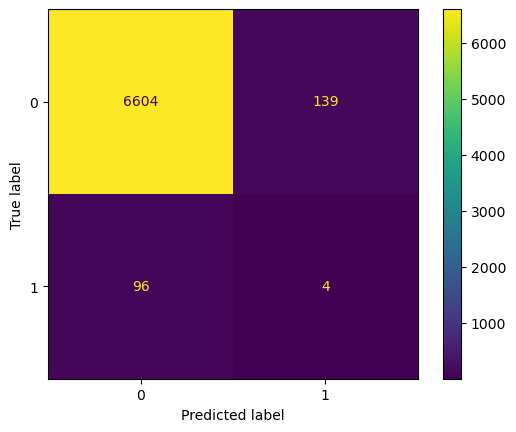

In [26]:
plot_confusion_matrix(fitted_randomgrid, X_validation, y_validation)

In [27]:
from sklearn.metrics import classification_report

y_pred=fitted_randomgrid.predict(X_validation)

print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6743
           1       0.03      0.04      0.03       100

    accuracy                           0.97      6843
   macro avg       0.51      0.51      0.51      6843
weighted avg       0.97      0.97      0.97      6843



### Take aways from first random search:
- initial random search had negligable improvements in performance. We will try again this time with the majority class downsampled to only 2x the minority class (the proprotion that appeared to work best with our lgoistic regression).


# Attempt with Non-injuries down sampled to only 2x the size of the injury class

In [28]:
#checking the number of non-injured vs injured, to set our resample accordingly
np.unique(y_train, return_counts= True)

(array([0, 1]), array([27003,   366]))

In [29]:
#calculating 2x the number of injuries
366*2

732

In [30]:
#Down sampling non-inj
X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                    y_train[y_train == 0], 
                                    replace=True, 
                                    n_samples=732,
                                    random_state=123)

print('Number of class 1 examples after:', X_downsampled.shape[0]) #clas 1 refering to non-injured

# Combine upsample with original data
X_train_DS2 = np.vstack((X_train[y_train == 1], X_downsampled)) 
y_train_DS2 = np.hstack((y_train[y_train == 1], y_downsampled))


Number of class 1 examples after: 732


In [31]:
np.unique(y_train_DS2, return_counts= True)

(array([0, 1]), array([732, 366]))

In [43]:
732/336


2.1785714285714284

Now we can see that the non-injuries are 2x the injuries.

### ReOptimize Scale Pos weight

Because we have adjusted the ratio of injured to non-injured we will reoptimixe the `scale_pos_weight`

In [81]:
#finding an optimal range for the subsample
pos_weight_list = range(0,150, 5)


train_scores = []
validation_scores = []

for d in pos_weight_list:
    print(f"Working on d={d}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(scale_pos_weight=d, n_jobs= -1)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))

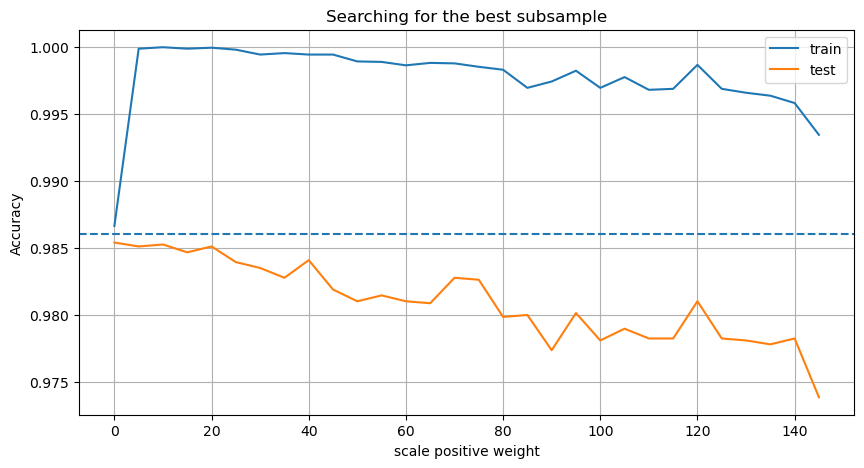

[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 5/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   0.0s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [82]:
pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=pos_weight_list
).plot(figsize=(10, 5))
plt.title("Searching for the best subsample")
plt.axhline(0.986, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('scale positive weight')
plt.grid()
plt.show()

In [87]:
#finding an optimal range for the subsample
pos_weight_list = range(0,20,1)


train_scores = []
validation_scores = []

for d in pos_weight_list:
    print(f"Working on d={d}...", end="\r") #PROTIP for progress bars...
    
    XGB_model_tuning = XGBClassifier(scale_pos_weight=d, n_jobs= -1)
    XGB_model_tuning.fit(X_train, y_train)
    
    train_scores.append(XGB_model_tuning.score(X_train, y_train))
    validation_scores.append(XGB_model_tuning.score(X_validation, y_validation))

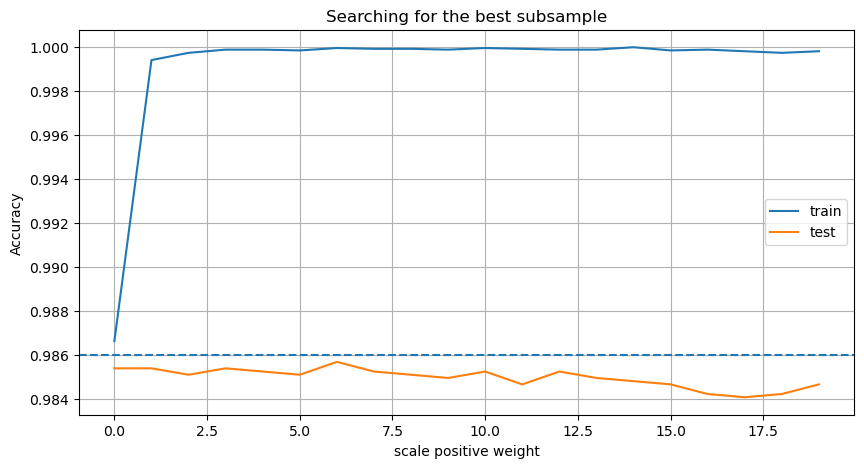

[CV 5/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=10, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=10, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   0.0s
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=10, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   0.1s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [88]:
pd.DataFrame(
    {"train": train_scores, "test": validation_scores}, index=pos_weight_list
).plot(figsize=(10, 5))
plt.title("Searching for the best subsample")
plt.axhline(0.986, linestyle = '--') #represents the %of inputs that are injuries
plt.ylabel('Accuracy')
plt.xlabel('scale positive weight')
plt.grid()
plt.show()

# Random Search attempt #2

In [103]:
# random search attempt with down sample
estimators = [
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
]

# create pipeline
xgb_pipe = Pipeline(estimators)


param_grid = [
    {
        'model': [XGBClassifier(scale_pos_weight=72.3)],
        'scaler': [StandardScaler()],
        'model__subsample':[0.2, 0.4, 0.6, 0.7],
        'model__max_depth': [2, 3, 4, 5],
        'model__n_estimators': range(5, 90, 5 ),
    }
]

Randomgrid = RandomizedSearchCV(xgb_pipe, param_grid, cv=5, verbose=3, scoring = 'f1_micro', random_state=1, n_iter=50, n_jobs=-1)

fitted_randomgrid_DS = Randomgrid.fit(X_train_DS2, y_train_DS2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=6, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_i

[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=6, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   0.0s
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,


[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=6, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,


[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=6, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   0.1s
[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,


In [104]:
fitted_randomgrid_DS.best_score_

0.6265794935657949

In [105]:
fitted_randomgrid_DS.best_params_

{'scaler': StandardScaler(),
 'model__subsample': 0.7,
 'model__n_estimators': 80,
 'model__max_depth': 5,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=5,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=80, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=72.3, subsample=0.7, tree_method=None,
               validate_parameters=None, verbosity=None)}

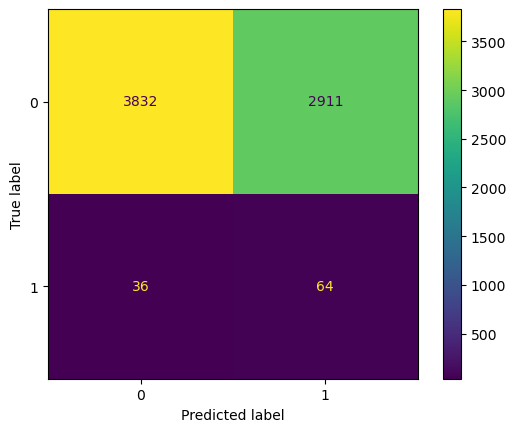

In [106]:
plot_confusion_matrix(fitted_randomgrid_DS, X_validation, y_validation)

In [107]:
from sklearn.metrics import classification_report

y_pred=fitted_randomgrid_DS.predict(X_validation)

print(classification_report(y_validation, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.57      0.72      6743
           1       0.02      0.64      0.04       100

    accuracy                           0.57      6843
   macro avg       0.51      0.60      0.38      6843
weighted avg       0.98      0.57      0.71      6843



### Take aways from Random Search 2

This approach of down sampling to only 1.5 times the injury appears to yeild the best result so far. Despite the low f1 and percision, recall is up to 64% which is more important when preventing injuries. 

We will attempt to use upsampling and see if that leads to any improvements in the models ability to predict injury.


# Up Sampling

First we will try upsampling exclusively (no down sampling). We will upsample the injuries to .5 the size of non-injuries so teh ratio of non--injured to injured is only 2:1.

In [138]:
#current spread
np.unique(y_train, return_counts= True)

(array([0, 1]), array([27003,   366]))

In [139]:
27003/2

13501.5

we will first up sample to 13501

In [140]:
#upsampling to 50-50 split
X_upsampled, y_upsampled = resample(X_train[y_train == 1], # injury features
                                    y_train[y_train == 1], # inj labels
                                    replace=True, 
                                    n_samples=13501,
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_US = np.vstack((X_train[y_train == 0], X_upsampled)) # same as concat with axis=0
y_train_US = np.hstack((y_train[y_train == 0], y_upsampled))



Number of class 1 examples after: 13501


In [141]:
#current spread
np.unique(y_train_US, return_counts= True)

(array([0, 1]), array([27003, 13501]))

Now there are 1/2 as many injuries as there are non-injuries.

In [161]:

estimators = [
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
]

# create pipeline
xgb_pipe = Pipeline(estimators)


param_grid = [
    {
        'model': [XGBClassifier(scale_pos_weight=2)],
        'scaler': [StandardScaler()],
        'model__subsample':[0.25, 0.5, 0.75, 1],
        'model__max_depth': [2, 4, 6, 8],
        'model__n_estimators': range(10, 200, 10 ),
        'model__learning_rate': [0.10,.2, 0.3, 0.75, 1]
    }
]

Randomgrid = RandomizedSearchCV(xgb_pipe, param_grid, cv=5, verbose=2, scoring='f1_micro', n_iter=20)

fittedgrid_US = Randomgrid.fit(X_train_US, y_train_US)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=60, model__subsample=0.5, scaler=StandardScaler(); total time=   9.3s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
 

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.75, model__max_depth=4, model__n_estimators=30, model__subsample=0.25, scaler=StandardScaler(); total time=   1.7s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interactio

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 1/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=15, model__subsample=0.7, scaler=StandardScaler(); total time=   0.1s
[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 2/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV 4/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=72.3, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=5, model__n_estimators=15, model__subsample=0.6, scaler=StandardScaler(); total time=   0.1s
[CV 3/5] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=Non

/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/johnfitzpatrick/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.2, model__max_depth=8, model__n_estimators=40, model__subsample=0.5, scaler=StandardScaler(); total time=   6.4s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.75, model__max_depth=6, model__n_estimators=170, model__subsample=1, scaler=StandardScaler(); total time=  19.1s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=2, model__n_estimators=150, model__subsample=0.75, scaler=StandardScaler(); total time=   6.3s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=10, model__subsample=0.25, scaler=StandardScaler(); total time=   1.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_c

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=130, model__subsample=1, scaler=StandardScaler(); total time=  20.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_c

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=160, model__subsample=0.5, scaler=StandardScaler(); total time=  12.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=50, model__subsample=1, scaler=StandardScaler(); total time=   7.5s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_co

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=150, model__subsample=0.25, scaler=StandardScaler(); total time=   8.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interactio

In [162]:
fittedgrid_US.best_score_

0.999639018224489

In [146]:
fittedgrid_US.best_params_

{'scaler': StandardScaler(),
 'model__subsample': 1,
 'model__n_estimators': 120,
 'model__max_depth': 8,
 'model__learning_rate': 0.3,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.3, max_delta_step=None, max_depth=8,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=120, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=2, subsample=1, tree_method=None,
               validate_parameters=None, verbosity=None)}

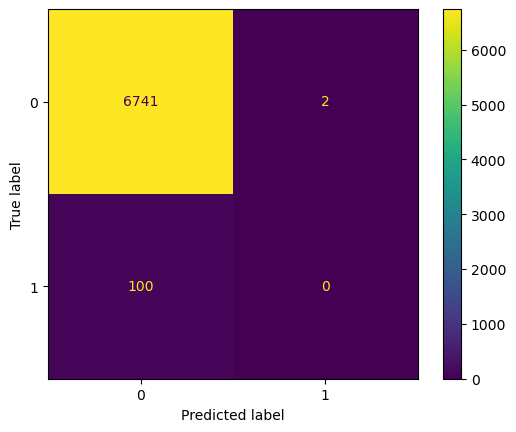

In [147]:
plot_confusion_matrix(fittedgrid_US, X_validation, y_validation)

In [148]:

y_pred=fittedgrid_US.predict(X_validation)

print(classification_report(y_validation, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6743
           1       0.00      0.00      0.00       100

    accuracy                           0.99      6843
   macro avg       0.49      0.50      0.50      6843
weighted avg       0.97      0.99      0.98      6843



We can see that the just upsampling has no effect in aiding with the improvement of predicting injuries.

# Upsampling and Down sampling to Equal Distribution

Next we will try up sampling and down sampling to equal distributions. We will down sample the non-injuries to only 2x the size of the injuries, (using our previously made downsample 2 re-sampled data), then upsample the injuries to 2x their original amount.

In [91]:
#current spread
np.unique(y_train_DS2, return_counts= True)

(array([0, 1]), array([732, 366]))

up sample injury to 732 so we have an even split

In [120]:
#upsampling to 50-50 split
X_upsampled, y_upsampled = resample(X_train_DS2[y_train_DS2 == 1], # injury features
                                    y_train_DS2[y_train_DS2 == 1], # inj labels
                                    replace=True, 
                                    n_samples=732,
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_EQ = np.vstack((X_train_DS2[y_train_DS2 == 0], X_upsampled)) # same as concat with axis=0
y_train_EQ = np.hstack((y_train_DS2[y_train_DS2 == 0], y_upsampled))



Number of class 1 examples after: 732


In [121]:
#current spread
np.unique(y_train_EQ, return_counts= True)

(array([0, 1]), array([732, 732]))

now we have an equal distribution


In [133]:

estimators = [
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
]

# create pipeline
xgb_pipe = Pipeline(estimators)


param_grid = [
    {
        'model': [XGBClassifier(scale_pos_weight=2)],
        'scaler': [StandardScaler()],
        'model__subsample':[0.25, 0.5, 0.75, 1],
        'model__max_depth': [2, 4, 6, 8],
        'model__n_estimators': range(10, 200, 10 ),
        'model__learning_rate': [0.10,.2, 0.3, 0.75, 1]
    }
]

Randomgrid = RandomizedSearchCV(xgb_pipe, param_grid, cv=5, verbose=2, scoring='f1_micro', n_iter=20)

fittedgrid_EQ = Randomgrid.fit(X_train_EQ, y_train_EQ)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.75, model__max_depth=2, model__n_estimators=150, model__subsample=0.25, scaler=StandardScaler(); total time=   0.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.2, model__max_depth=6, model__n_estimators=90, model__subsample=0.25, scaler=StandardScaler(); total time=   0.3s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=30, model__subsample=0.25, scaler=StandardScaler(); total time=   0.1s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=160, model__subsample=0.5, scaler=StandardScaler(); total time=   0.5s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=160, model__subsample=0.5, scaler=StandardScaler(); total time=   0.9s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.2, model__max_depth=4, model__n_estimators=80, model__subsample=1, scaler=StandardScaler(); total time=   0.3s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_co

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=1, model__max_depth=6, model__n_estimators=40, model__subsample=0.5, scaler=StandardScaler(); total time=   0.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_co

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=60, model__subsample=0.75, scaler=StandardScaler(); total time=   0.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=2, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100, model__subsample=0.5, scaler=StandardScaler(); total time=   0.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction

In [134]:
fittedgrid_EQ.best_score_

0.8504044134835664

In [135]:
fittedgrid_EQ.best_params_

{'scaler': StandardScaler(),
 'model__subsample': 0.75,
 'model__n_estimators': 160,
 'model__max_depth': 8,
 'model__learning_rate': 0.2,
 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=0.2, max_delta_step=None, max_depth=8,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=160, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=2, subsample=0.75, tree_method=None,
               validate_parameters=None, verbosity=None)}

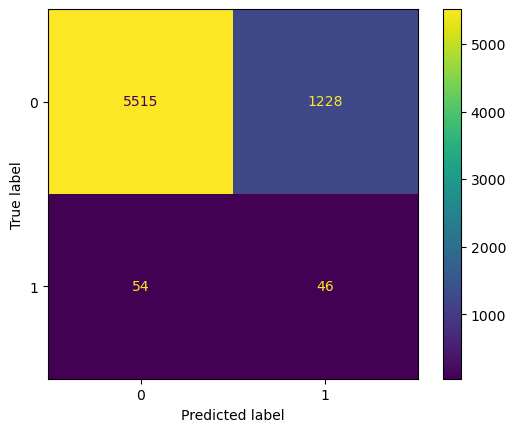

In [136]:
plot_confusion_matrix(fittedgrid_EQ, X_validation, y_validation)

In [137]:

y_pred=fittedgrid_EQ.predict(X_validation)

print(classification_report(y_validation, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.82      0.90      6743
           1       0.04      0.46      0.07       100

    accuracy                           0.81      6843
   macro avg       0.51      0.64      0.48      6843
weighted avg       0.98      0.81      0.88      6843



### Up- and Downsample take aways:
While this approach actually yeilds the best f1 score so far (7%), there is a decrese in the model's recall (46%) compared to the 2nd down sampled model which had a recall of 64%. 


# Checking feature importance

We will now investigate the feature importance within the xgboost model based on how much each attribute-split-point, improves the perfromence measure.

source:https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

We will check our feature importance witht the initial XGBoost model prior to optimizing (as adding the hyperparameters makes the plot less interpretable but results in little change in order of importance)

In [152]:
# fit model no training data
from xgboost import plot_importance

model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

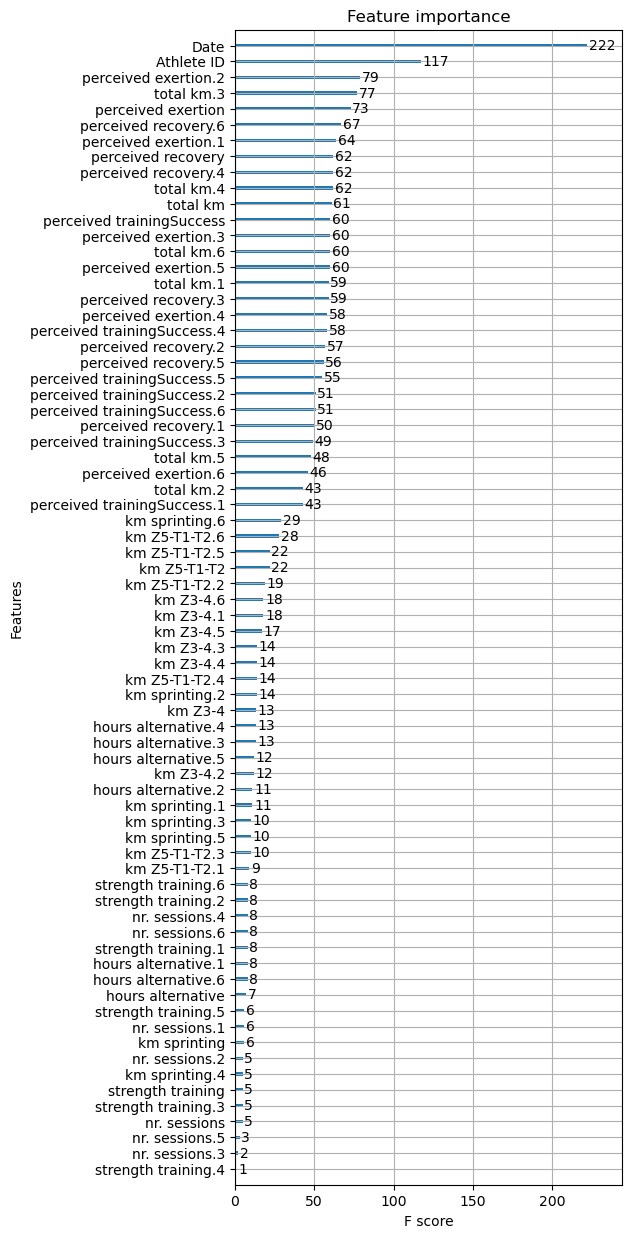

In [153]:
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(5, 15)

### Feature importance take aways:
- `Date` and `Athelte ID` stand out as features of importance. These both make sense seeing as atheltes could reach a certain depth in training where injury is more likely, and particular atheltes being more prone to injury.
- `perceived-` metrics (success, recovery and exertion) all appear to be in the upper half of important features
- `nr.sessions`, as is `strength training`, `km sprinting`, and `hours alternative`
> - this could mean that doing such is **less** correlated with injury 


# Finally we will look into alternative scoring

In reading the study which collected the data, they appeared to have been relatively satisfied with the result. Upon further review it appears they were using ROC AUC score, which makes more sense why they had a more satisfactory result.

Roc Auc score represents represents the area under the curve. If the score is 0.5 (represented by a diagonal line) there the model has noability for class seperation, if it is bellow that then it is bellow the diagonal line then it is mis classifying, and if the curve is tucked into the top left then it is classifying perfectly.
represents___

We will now run our best model with this same scoring, bellow.

In [194]:
# random search attempt with down sample
from sklearn.metrics import roc_auc_score
estimators = [
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
]

# create pipeline
xgb_pipe = Pipeline(estimators)


param_grid = [
    {
        'model': [XGBClassifier(scale_pos_weight=72.3)],
        'scaler': [StandardScaler()],
        'model__subsample':[0.2, 0.4, 0.6, 0.7],
        'model__max_depth': [2, 3, 4, 5],
        'model__n_estimators': range(5, 90, 5 ),
    }
]

Randomgrid = RandomizedSearchCV(xgb_pipe, param_grid, cv=5, verbose=3, scoring = 'roc_auc', random_state=1, n_iter=50, n_jobs=-1)

fitted_randomgrid_DS_roc = Randomgrid.fit(X_train_DS2, y_train_DS2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [199]:
### Calculating ROC_AUC score
pred_prob1 = fitted_randomgrid_DS_roc.predict_proba(X_validation)


auc_score1 = roc_auc_score(y_validation, pred_prob1[:,1])

print(auc_score1)

0.6647990508675663


Our best perfroming model yeilded a ROC AUC score of 66%. We will illustrate this on the model bellow.

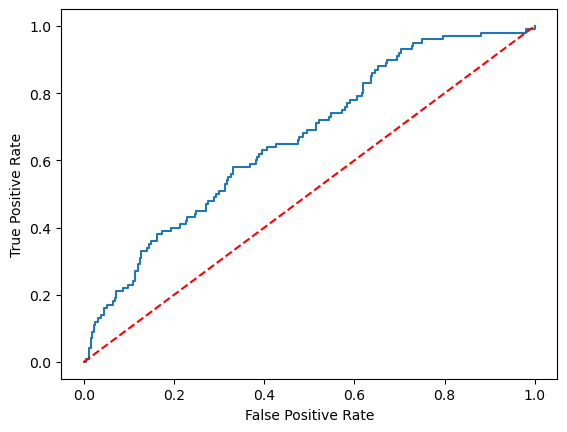

In [183]:
# option 2
from sklearn import metrics


#define metrics
y_pred_proba = fitted_randomgrid_DS_roc.predict_proba(X_validation)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_validation,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.show()


auc= probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance


tbh idk what this means^



# Model Evaluation on True Test Set

Finally we wil also evaluate the our best performing model (the down sample), on our actual test set. 

* StandardScaler(),
* 'scale_pos_weight': 72.3
* 'model__subsample': .07,
* 'model__n_estimators': 80,
* 'model__max_depth': 5

In [204]:
np.unique(y_remainder, return_counts= True)

(array([0, 1]), array([33746,   466]))

In [205]:
33746/466

72.41630901287553

In [200]:
#scaling data
scaler = StandardScaler()
scaler.fit(X_remainder)
X_remainder = scaler.transform(X_remainder)
X_test = scaler.transform(X_test)

In [201]:
#fitting and running a model with the optimized parameters
XGB_model_final = XGBClassifier(scale_pos_weight=72.3, n_estimators=80, max_depth=5, subsample=.7)
XGB_model_final.fit(X_remainder, y_remainder)
print(f"XG Boost score: {XGB_model_final.score(X_test, y_test)}")


XG Boost score: 0.9497311199438859


of course we will ignore teh accuracy score and check the ROC and F1 scores 

In [202]:
y_pred=XGB_model_final.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8437
           1       0.04      0.11      0.06       117

    accuracy                           0.95      8554
   macro avg       0.51      0.54      0.52      8554
weighted avg       0.97      0.95      0.96      8554



ON the test set the model has a slightly higher f1 score, (6% compared to 4% on with the validation set),likely due to the slight increase in percision (4%) however it has a signiicantly lower recall, (11% compared to the 64% earlier). 

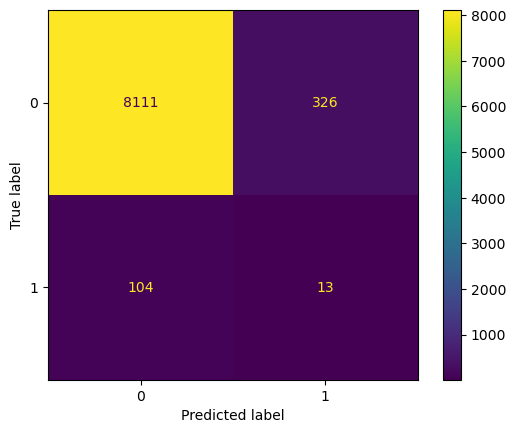

In [203]:
plot_confusion_matrix(XGB_model_final, X_test, y_test)

The confusion matriz above shows the models perfromance. DEspite classifying far fewer false-injuries, over 104 out of the 117 injuries were missed. 


In [208]:
### Calculating ROC_AUC score
pred_prob2 = XGB_model_final.predict_proba(X_test)


auc_score2 = roc_auc_score(y_test, pred_prob1[:,1])

print(auc_score1)

0.6459454640680196


Our best perfroming model yeilded a ROC AUC score of 66%. We will illustrate this on the model bellow.

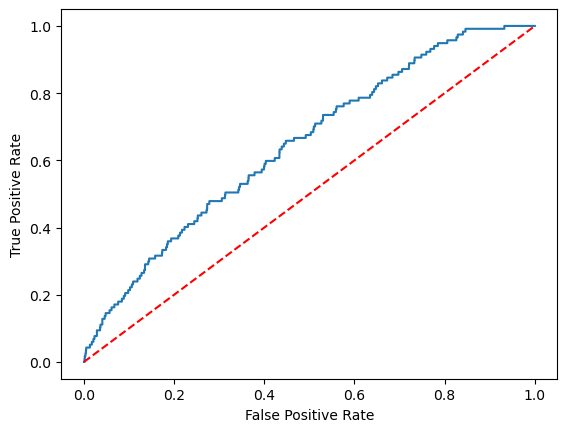

In [209]:
# option 2
from sklearn import metrics


#define metrics
y_pred_proba = XGB_model_final.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.show()

Once again we see a similar curve, if anything it is slightly closer to the 0.5 rate, meaning a relatively unimpressive ROC AUC score, (once again in the mid 60's).

# Conclusion

Our XGBoost model was able to be optimized to the point of having 64% recall on a validation set, how ever, it did not perfrom as well on the true test set. Unfortunately due to the strong imbalance in the data it still proved difficult to work around. In the next note book we will investigate further steps.